Loading data...
Original shape: (2980, 59)

Column names:
['sample_id', 'coating', '%Cr', '%Ni', '%Mo', '%C', '%Mn', '%Si', '%Cu', '%N', 'temperature_C', 'chloride_ppm', 'pH', 'resistivity_ohm_m', 'flow_rate_m_s', 'relative_humidity_%', 'exposure_days', 'PREN', 'Cr_Ni_ratio', 'log_chloride', 'marine_severity_index', 'relative_resistance_index', 'corrosion_rate_mm_per_year', 'risk_level', 'source_reference', '_Unnamed_', 'Notes', 'OH_conc', 'Cl_OH_ratio', 'temp_x_logCl', 'log_exposure_days', 'sqrt_exposure_days', 'Cr_Mo_ratio', 'Ni_Mo_ratio', 'CrxNi', 'CrxMo', 'coating_bin', 'inv_resistivity', 'log_chloride_sq', 'PREN_sq', 'temperature_C_sq', 'pH_sq', 'material_mean_rate', 'material_std_rate', 'environment_mean_rate', 'environment_std_rate', 'material_AISI316L', 'material_AISI410', 'material_AISI430', 'material_AISI444', 'material_Duplex2205', 'environment_Cementitious', 'environment_Marine', 'environment_Soil', 'is_outlier_rate', '%Mo_was_missing', 'pH_was_missing', 'chloride_ppm_was_m

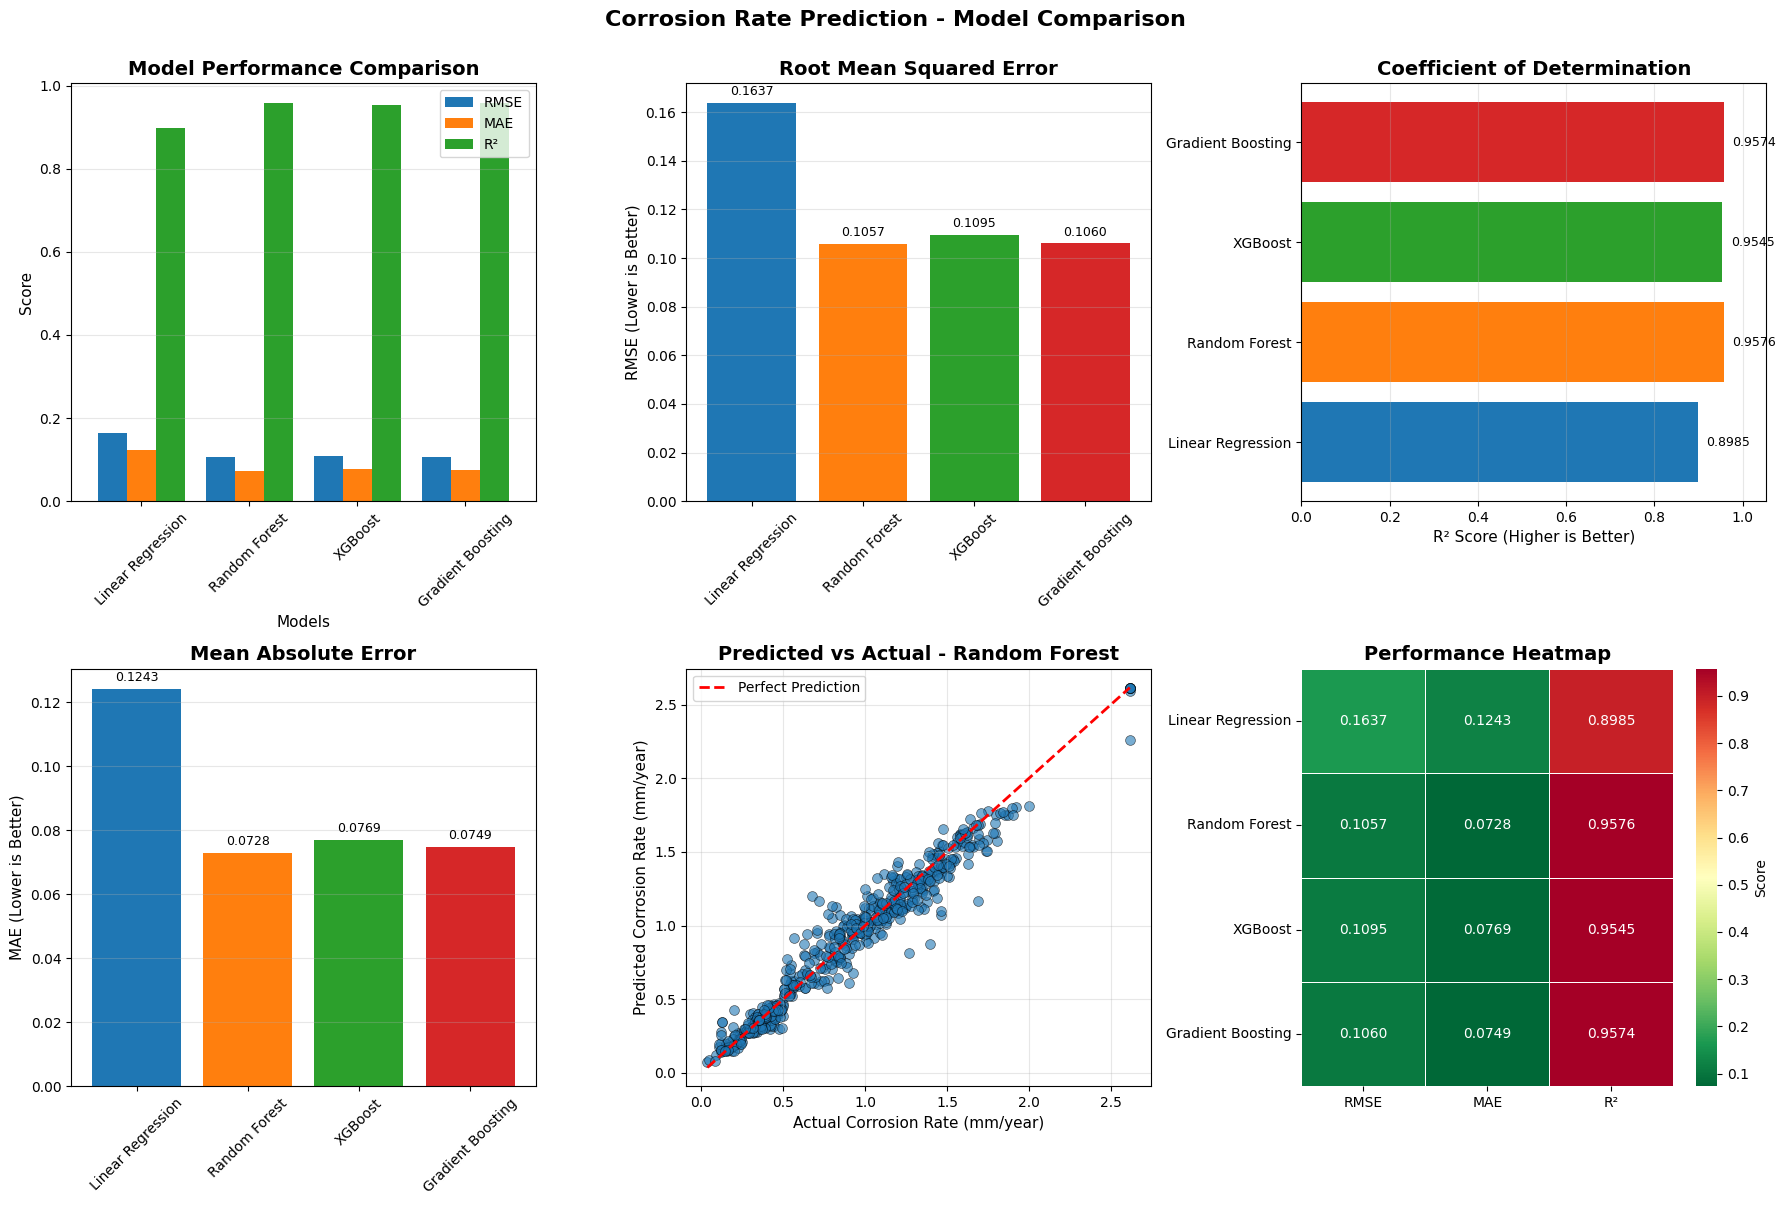


Generating residual plot...
  ✓ Saved: residual_plot.png


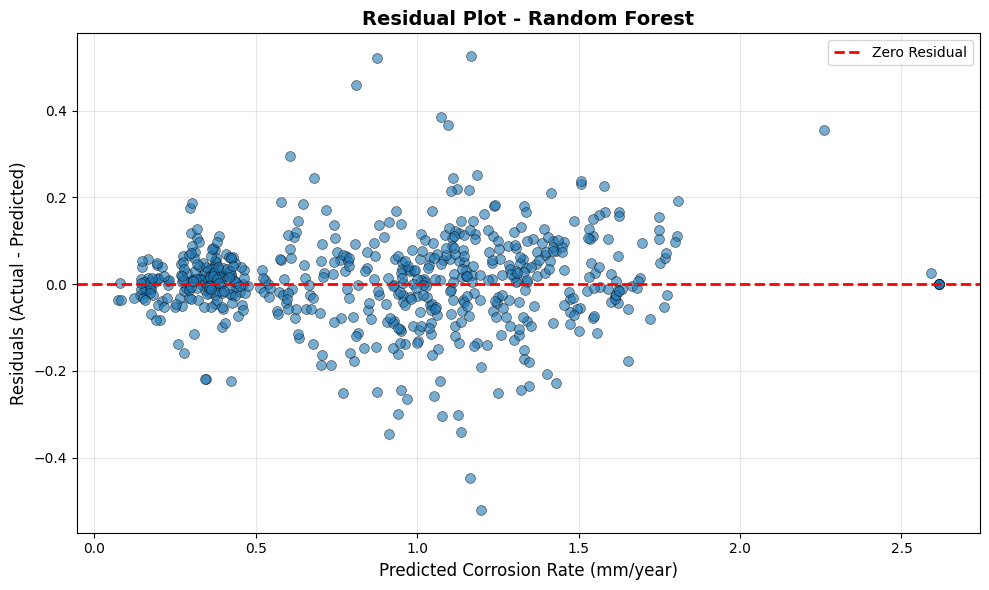


DETAILED RESULTS

Linear Regression:
  RMSE:      0.1637
  MAE:       0.1243
  R² Score:  0.8985

Random Forest:
  RMSE:      0.1057
  MAE:       0.0728
  R² Score:  0.9576

XGBoost:
  RMSE:      0.1095
  MAE:       0.0769
  R² Score:  0.9545

Gradient Boosting:
  RMSE:      0.1060
  MAE:       0.0749
  R² Score:  0.9574

🏆 BEST MODEL: Random Forest
  RMSE:      0.1057
  MAE:       0.0728
  R² Score:  0.9576

SUMMARY TABLE
                       RMSE       MAE        R2
Random Forest      0.105749  0.072847  0.957615
Gradient Boosting  0.105999  0.074858  0.957414
XGBoost            0.109536  0.076918  0.954525
Linear Regression  0.163684  0.124298  0.898451

✅ Analysis complete!
📊 Check the generated plots: model_comparison.png and residual_plot.png


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load data
print("Loading data...")
# NOTE: Assumes 'Corrosion_Featured.xlsx' is available in the execution environment
df = pd.read_excel("Corrosion_Featured.xlsx")

print(f"Original shape: {df.shape}")
print(f"\nColumn names:\n{df.columns.tolist()}")

# Drop specified columns
columns_to_drop = ['_Unnamed_', 'Notes']
df = df.drop(columns=columns_to_drop, errors='ignore')

print(f"\nShape after dropping columns: {df.shape}")

# Display basic info
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())

# Separate features and target
target_col = 'corrosion_rate_mm_per_year'
print(f"\nTarget column: {target_col}")
print(f"\nTarget statistics:")
print(df[target_col].describe())

X = df.drop(columns=[target_col])
y = df[target_col]

# Handle categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print(f"\nCategorical columns ({len(categorical_cols)}): {categorical_cols}")
print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")

# Encode categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    # Ensure all categorical columns are treated as strings before encoding
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le
    print(f"  Encoded '{col}': {len(le.classes_)} unique values")

# Handle missing values in features
if X.isnull().sum().sum() > 0:
    print("\nFilling missing values with median...")
    X = X.fillna(X.median())

# Remove any rows with missing target values
if y.isnull().sum() > 0:
    print(f"\nRemoving {y.isnull().sum()} rows with missing target values...")
    mask = ~y.isnull()
    X = X[mask]
    y = y[mask]

print(f"\nFinal dataset shape: {X.shape}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Initialize regression models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBRegressor(random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Train and evaluate models
results = {}

print("\n" + "="*70)
print("TRAINING MODELS")
print("="*70)

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Use scaled data for Linear Regression, original for tree-based models
    if name == 'Linear Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'predictions': y_pred
    }

    print(f"  ✓ RMSE: {rmse:.4f}")
    print(f"  ✓ MAE: {mae:.4f}")
    print(f"  ✓ R² Score: {r2:.4f}")

# --- FIX START: Centralize Best Model Definition ---
# Identify the Best Model for subsequent plotting and reporting
best_model_tuple = max(results.items(), key=lambda x: x[1]['R2'])
best_model_name = best_model_tuple[0]
best_model_metrics = best_model_tuple[1]
y_pred_best = best_model_metrics['predictions']
# --- FIX END ---

# Create comparison plots
print("\nGenerating comparison plots...")
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Corrosion Rate Prediction - Model Comparison', fontsize=16, fontweight='bold', y=1.00)

# 1. Metrics Comparison - Bar Plot
metrics_df = pd.DataFrame({
    model: [results[model]['RMSE'], results[model]['MAE'], results[model]['R2']]
    for model in results.keys()
}, index=['RMSE', 'MAE', 'R²'])

metrics_df.T.plot(kind='bar', ax=axes[0, 0], rot=45, width=0.8)
axes[0, 0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Score', fontsize=11)
axes[0, 0].set_xlabel('Models', fontsize=11)
axes[0, 0].legend(loc='upper right', fontsize=10)
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. RMSE Comparison
rmse_data = {model: results[model]['RMSE'] for model in results.keys()}
bars = axes[0, 1].bar(list(rmse_data.keys()), list(rmse_data.values()),
                      color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[0, 1].set_ylabel('RMSE (Lower is Better)', fontsize=11)
axes[0, 1].set_title('Root Mean Squared Error', fontsize=14, fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=45)
for i, (bar, v) in enumerate(zip(bars, rmse_data.values())):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, v + max(rmse_data.values())*0.02,
                    f'{v:.4f}', ha='center', fontsize=9)
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. R² Score Comparison
r2_data = {model: results[model]['R2'] for model in results.keys()}
bars = axes[0, 2].barh(list(r2_data.keys()), list(r2_data.values()),
                       color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[0, 2].set_xlabel('R² Score (Higher is Better)', fontsize=11)
axes[0, 2].set_title('Coefficient of Determination', fontsize=14, fontweight='bold')
axes[0, 2].set_xlim([0, max(r2_data.values()) * 1.1])
for i, (bar, v) in enumerate(zip(bars, r2_data.values())):
    axes[0, 2].text(v + max(r2_data.values())*0.02, bar.get_y() + bar.get_height()/2,
                    f'{v:.4f}', va='center', fontsize=9)
axes[0, 2].grid(axis='x', alpha=0.3)

# 4. MAE Comparison
mae_data = {model: results[model]['MAE'] for model in results.keys()}
bars = axes[1, 0].bar(list(mae_data.keys()), list(mae_data.values()),
                      color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[1, 0].set_ylabel('MAE (Lower is Better)', fontsize=11)
axes[1, 0].set_title('Mean Absolute Error', fontsize=14, fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)
for i, (bar, v) in enumerate(zip(bars, mae_data.values())):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, v + max(mae_data.values())*0.02,
                    f'{v:.4f}', ha='center', fontsize=9)
axes[1, 0].grid(axis='y', alpha=0.3)

# 5. Predicted vs Actual for Best Model
# Using pre-calculated best_model_name and y_pred_best
axes[1, 1].scatter(y_test, y_pred_best, alpha=0.6, edgecolors='k', linewidth=0.5, s=50)
min_val = min(y_test.min(), y_pred_best.min())
max_val = max(y_test.max(), y_pred_best.max())
axes[1, 1].plot([min_val, max_val], [min_val, max_val],
                'r--', lw=2, label='Perfect Prediction')
axes[1, 1].set_xlabel('Actual Corrosion Rate (mm/year)', fontsize=11)
axes[1, 1].set_ylabel('Predicted Corrosion Rate (mm/year)', fontsize=11)
axes[1, 1].set_title(f'Predicted vs Actual - {best_model_name}', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(alpha=0.3)

# 6. Performance Heatmap
performance_matrix = []
for model in results.keys():
    performance_matrix.append([
        results[model]['RMSE'],
        results[model]['MAE'],
        results[model]['R2']
    ])

sns.heatmap(performance_matrix, annot=True, fmt='.4f', cmap='RdYlGn_r',
            xticklabels=['RMSE', 'MAE', 'R²'],
            yticklabels=list(results.keys()), ax=axes[1, 2],
            cbar_kws={'label': 'Score'}, linewidths=0.5)
axes[1, 2].set_title('Performance Heatmap', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: model_comparison.png")
plt.show()

# Create residual plot for best model
print("\nGenerating residual plot...")
fig2, ax = plt.subplots(1, 1, figsize=(10, 6))
# FIX: Use the explicit variable y_pred_best for residuals and plotting
residuals = y_test.values - y_pred_best
ax.scatter(y_pred_best, residuals, alpha=0.6,
           edgecolors='k', linewidth=0.5, s=50)
ax.axhline(y=0, color='r', linestyle='--', linewidth=2, label='Zero Residual')
ax.set_xlabel('Predicted Corrosion Rate (mm/year)', fontsize=12)
ax.set_ylabel('Residuals (Actual - Predicted)', fontsize=12)
# FIX: Use the explicit variable best_model_name for the title
ax.set_title(f'Residual Plot - {best_model_name}', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('residual_plot.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: residual_plot.png")
plt.show()

# Print detailed results
print("\n" + "="*70)
print("DETAILED RESULTS")
print("="*70)
for model, metrics in results.items():
    print(f"\n{model}:")
    print(f"  RMSE:      {metrics['RMSE']:.4f}")
    print(f"  MAE:       {metrics['MAE']:.4f}")
    print(f"  R² Score:  {metrics['R2']:.4f}")

# Print best model summary using the pre-calculated metrics
print(f"\n{'='*70}")
print(f"🏆 BEST MODEL: {best_model_name}")
print(f"{'='*70}")
print(f"  RMSE:      {best_model_metrics['RMSE']:.4f}")
print(f"  MAE:       {best_model_metrics['MAE']:.4f}")
print(f"  R² Score:  {best_model_metrics['R2']:.4f}")
print(f"{'='*70}")

# Summary table
print("\n" + "="*70)
print("SUMMARY TABLE")
print("="*70)
summary_df = pd.DataFrame(results).T
summary_df = summary_df[['RMSE', 'MAE', 'R2']]
summary_df = summary_df.sort_values('R2', ascending=False)
print(summary_df.to_string())
print("="*70)

print("\n✅ Analysis complete!")
print("📊 Check the generated plots: model_comparison.png and residual_plot.png")